In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import sys, os
sys.path.append('../smc')

In [287]:
import numpy as np   
import pandas as pd
import pdb
import matplotlib.pyplot as plt
import scipy.stats as stats
import seaborn as sns
from tqdm import tqdm
import sys

In [288]:
from utils import *     # contains some useful helper functions 
from models import *    # toy models
from solvers import *   # matrix completion solvers
from methods import *

In [275]:
# Matrix shape and rank
n1, n2 = 100,100
k = 5
r = 3
prob_obs = 0.2
random_state = 0
allow_inf = False

In [219]:
sampler = QuerySampling(n1,n2)
size_obs = n1 * n2 * prob_obs
n_calib_queries = int(size_obs//(2*k))

# Split observation mask and test mask
mask_obs, mask_test = sampler.sample_submask(size_obs, random_state=random_state)

# Sample calibration queries 
mask_train, idxs_calib, mask_calib = sampler.sample_train_calib(mask_obs, n_calib_queries, k, random_state)

# Sample test queries
n_test_queries = min(np.sum(np.sum(mask_test, axis=1) // k), 1000)
_, idxs_test, _ = sampler.sample_train_calib(mask_test, n_test_queries, k, random_state=random_state)

In [220]:
# Generate a random true matrix 
RFM = RandomFactorizationModel(n1 ,n2, r)
U, V, M = RFM.sample_noiseless(random_state)

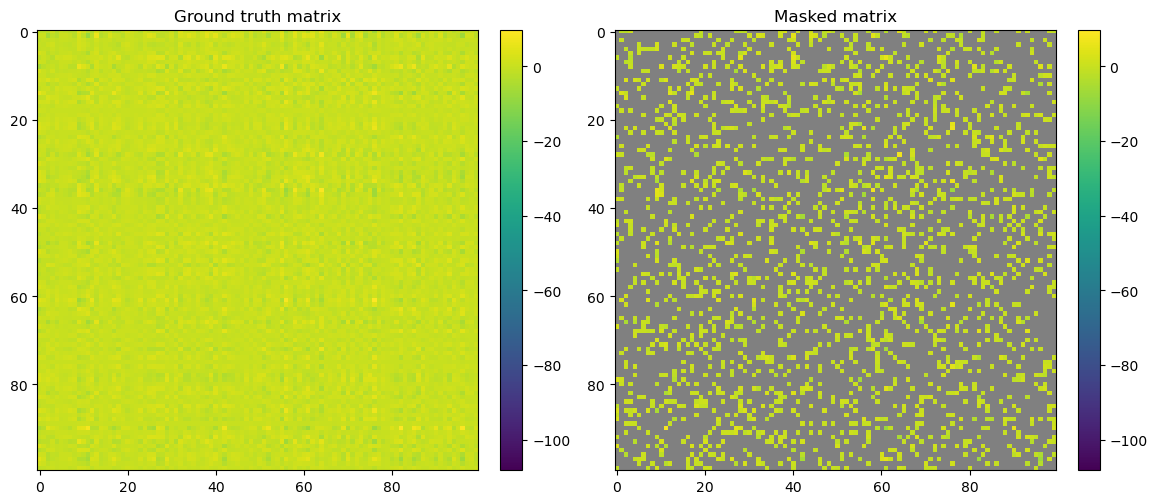

Missing entries are masked in grey.
Observation size: 2000, training size: 1000, calib size: 1000, calib queries: 200


In [221]:
assert np.all(mask_train+mask_calib==mask_obs),'Sampling error!'
vmin, vmax = np.min(M)-100, np.max(M)
plot_before_after_mask(M, mask_obs, vmin, vmax)
print("Missing entries are masked in grey.")
print("Observation size: {}, training size: {}, calib size: {}, calib queries: {}"
      .format(np.sum(mask_obs), np.sum(mask_train), np.sum(mask_calib), n_calib_queries))

In [222]:
gamma_n = 0.5
gamma_m = 0.9
a, b = 1,1
noise_model = "step"
alpha = 0.1
mu = 30

nm = NoiseModel(random_state)
M = nm.get_noisy_matrix(M, gamma_n=gamma_n, gamma_m=gamma_m, model=noise_model, 
                        a=a, b=b, mu=mu, alpha=alpha, normalize=False)

In [223]:
solver = "pmf"
verbose = False

print("Running matrix completion algorithm on the splitted training set...")
if solver == "pmf":
    Mhat, _, _ = pmf_solve(M, mask_train, k=r, verbose=verbose, random_state=random_state)
elif solver == "svt":
    Mhat = svt_solve(M, mask_train, verbose = verbose, random_state = random_state)
print("Done training!\n")

Running matrix completion algorithm on the splitted training set...
Done training!



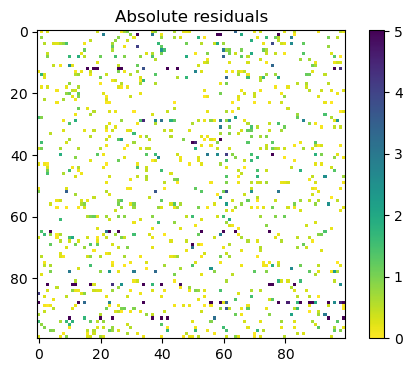

In [224]:
# some rows have larger residuals
error_heatmap(M, Mhat, mask_calib, bad_color="white")

In [244]:
def noisy_oracle(M, a=1, b=1, gamma=0.9, random_state=0):
    rng = np.random.default_rng(random_state)
    
    n1, n2 = M.shape
    
    # Generate noise with beta distribution, each row has the same residual 
    row_residual = rng.beta(a,b,n1)
    residual = np.transpose(np.tile(row_residual, (n2,1)))
    residual /= np.max(residual)     # normalize
     
    # Generate gaussian noise independent at each entry
    noise = rng.normal(0,1,M.shape)
    noise /= np.max(np.abs(noise))   # normalize
    
    # add a tunning parameter to control the correlation within entries in each row
    Mhat = M + gamma*residual + (1-gamma)*noise
    
    return Mhat

In [245]:
# Toggle gamma to see the row wise correlation
Mhat =  noisy_oracle(M, a=0.1, b=100, gamma=0.99, random_state=0)

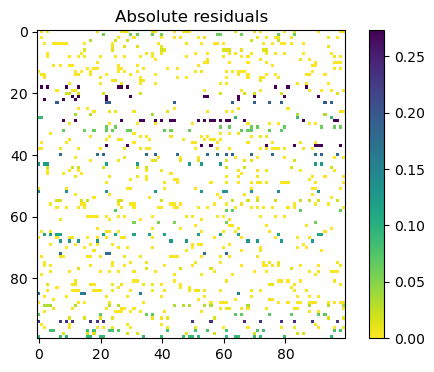

In [246]:
# some rows have larger residuals
error_heatmap(M, Mhat, mask_calib)

In [266]:
sci = SimulCI(M, Mhat, mask_obs, idxs_calib, k)

In [277]:
lower, upper, is_inf, _ = sci.get_CI(idxs_test, alpha)

Computing conformal prediction intervals for 1000 test queries...


CI: 100%|██████████████████████████████████████████████████████████████████████████| 1000/1000 [07:39<00:00,  2.18it/s]

Done!


In [289]:
res = evaluate_SCI(lower, upper, k, M, idxs_test, is_inf, method=None)

In [290]:
res

,Query_coverage,Coverage,Size,Inf_prop
0,0.903,0.9108,0.278398,0.0


In [291]:
def benchmark_CI(M, Mhat, idxs_calib, idxs_test, alpha, verbose = True):
    n_test_pairs = len(idxs_test[0])/k
    alpha_corrected = alpha / 2
    
    if verbose:
        print("Computing prediction intervals with Bonferroni correction with alpha {} for {} test pairs...".format(alpha, n_test_pairs))
        sys.stdout.flush()

    residuals = np.abs(M - Mhat)
    residual_calib = residuals[idxs_calib]

    est = Mhat[idxs_test]
    qnt = np.quantile(residual_calib, 1 - alpha_corrected, method="lower")
    lower, upper = est - qnt, est + qnt   
    
    if verbose:
        print("Done!")
        sys.stdout.flush()
        
    return lower, upper